# Overview

The goal of this notebook is to find and test different ways of clustering phone screen view data as a preprocessing step before
further extraction and classification. The main focus is placed on spacial data.

In [6]:
import numpy as np
import pandas as pd
from typing import Optional
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [7]:
coupon_df = pd.read_csv('data/18929485529.csv')
coupon_df.head()

,ID,User ID,Time,I,Language,Application Name,Package Name,Class Name,Context,View ID,View Depth,View Class Name,Text,Description,Seen Timestamp,Is Visible,X 1,Y 1,X 2,Y 2
0,18929485529,165559,2024-09-04T10:55:25.287,1,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,0,de.penny.app.main.view.MainActivity,NaN,NaN,0,False,0,0,0,0
1,18929485529,165559,2024-09-04T10:55:25.287,2,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,android:id/content,2,android.widget.FrameLayout,NaN,NaN,1725440082464,True,0,0,1080,2400
2,18929485529,165559,2024-09-04T10:55:25.287,3,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 14.99,NaN,1725440082464,True,339,833,498,874
3,18929485529,165559,2024-09-04T10:55:25.287,4,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,9.99,NaN,1725440082464,True,356,884,482,960
4,18929485529,165559,2024-09-04T10:55:25.287,5,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440082464,True,63,986,125,1027


In [8]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = min(x1, x2)
        self.y1 = min(y1, y2)
        self.x2 = max(x1, x2)
        self.y2 = max(y1, y2)

    def intersects(self, other: 'BoundingBox') -> bool:
        if self.x1 >= other.x2 or self.x2 <= other.x1:
            return False

        if self.y1 >= other.y2 or self.y2 <= other.y1:
            return False

        return True

    def merge(self, other: 'BoundingBox') -> 'BoundingBox':
        return BoundingBox(
            min(self.x1, other.x1),
            min(self.y1, other.y1),
            max(self.x2, other.x2),
            max(self.y2, other.y2)
        )

    def intersection(self, other: 'BoundingBox') -> Optional['BoundingBox']:
        if not self.intersects(other):
            return None

        return BoundingBox(
            max(self.x1, other.x1),
            max(self.y1, other.y1),
            min(self.x2, other.x2),
            min(self.y2, other.y2)
        )

    def area(self):
        return (self.x2 - self.x1) * (self.y2 - self.y1)

    def IoU(self, other: 'BoundingBox'):
        if not self.intersects(other):
            return 0

        inter_area = self.intersection(other).area()

        return inter_area / (self.area() + other.area() - inter_area)

    def apply_bias(self, xbias, ybias):
        return BoundingBox(
            self.x1 - xbias,
            self.y1 - ybias,
            self.x2 + xbias,
            self.y2 + ybias
        )

In [9]:
def create_bounding_box(row):
    return BoundingBox(
        row['X 1'],
        row['Y 1'],
        row['X 2'],
        row['Y 2']
    )

coupon_df_mod = coupon_df.copy()
coupon_df_mod['Bounding Box'] = coupon_df_mod.apply(create_bounding_box, axis=1)
coupon_df_mod.drop(columns=['X 1', 'Y 1', 'X 2', 'Y 2'], inplace=True)

I group data by 'Application Name', since view elements from different applications should not be a part of
the same cluster and 'Seen Timestamp', since the bounding box data will be unreliable at different points in time.

In [10]:
grouping_columns = ['Application Name', 'Seen Timestamp']
grouped_coupon_dfs = [group for _, group in coupon_df_mod.groupby(grouping_columns)]

I choose a group of view elements, that I will be using to roughly test the clustering algorithms and calculate their distance
matrix. The distance that will be used in this part is the inverse of the Jaccard index of bounding boxes, where
in the case of no intersection an arbitrarily large value is taken. To address the issue of the lack of intersection between the
bounding boxes I introduce an xbias and a ybias which will enlarge the bounding boxes in the x and y dimension respectively.

In [12]:
test_df = grouped_coupon_dfs[3]
num_rows = test_df.shape[0]
dists = np.empty((num_rows, num_rows))
xbias = 10
ybias = 100

for i in range(num_rows):
    for j in range(num_rows):
        dists[i, j] = 1 / (test_df['Bounding Box'].iloc[i].apply_bias(xbias, ybias).IoU(test_df['Bounding Box'].iloc[j].apply_bias(xbias, ybias)) + 1e-6)

print(dists)

[[9.99999000e-01 2.00774651e+00 1.00000000e+06 2.73287069e+01
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06]
 [2.00774651e+00 9.99999000e-01 1.00000000e+06 9.08929533e+00
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06]
 [1.00000000e+06 1.00000000e+06 9.99999000e-01 9.27078771e+00
  6.22104706e+00 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06]
 [2.73287069e+01

I draw dendrograms for hierarchical clustering results for single, average and complete linkage.

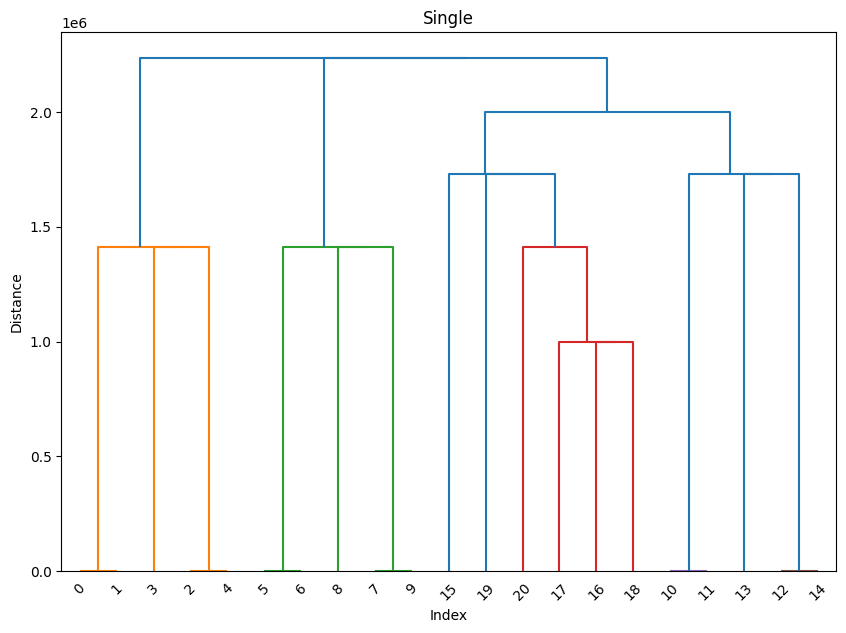

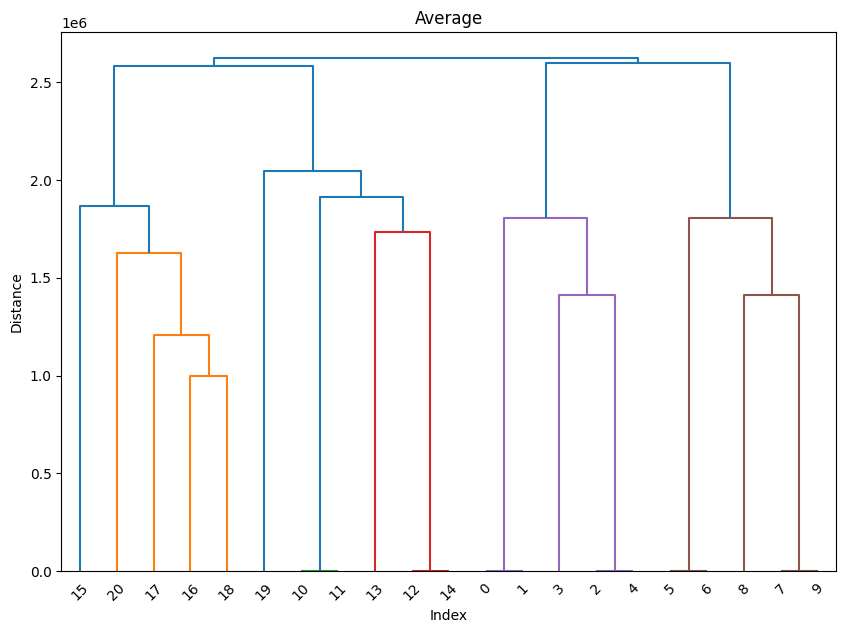

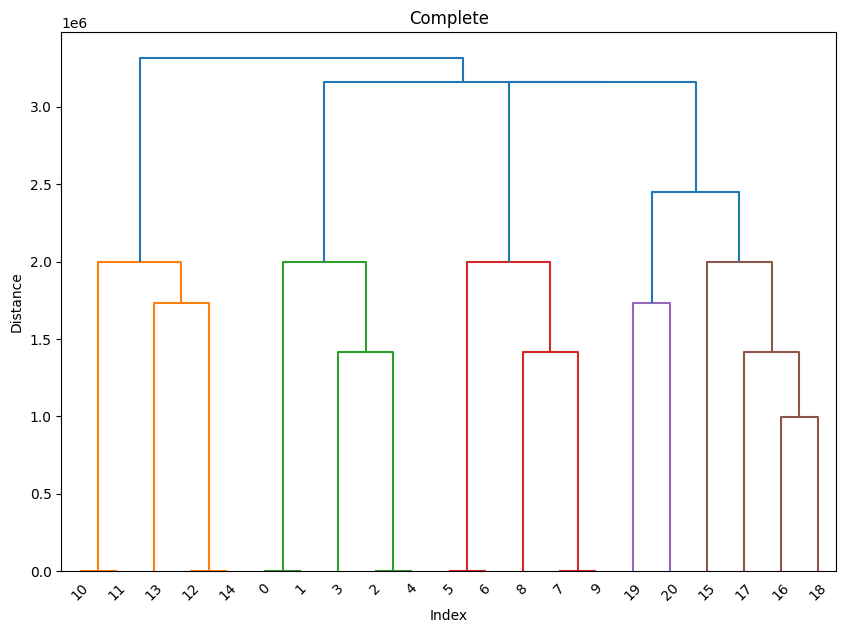

In [13]:
link_mat_single = linkage(dists, method='single')
link_mat_average = linkage(dists, method='average')
link_mat_complete = linkage(dists, method='complete')

plt.figure(figsize=(10, 7))
dendrogram(link_mat_single)
plt.title('Single')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(link_mat_average)
plt.title('Average')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(link_mat_complete)
plt.title('Complete')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

In [59]:
coupon_df[39:55]

,ID,User ID,Time,I,Language,Application Name,Package Name,Class Name,Context,View ID,View Depth,View Class Name,Text,Description,Seen Timestamp,Is Visible,X 1,Y 1,X 2,Y 2
39,18929485529,165559,2024-09-04T10:55:25.287,40,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 14.99,NaN,1725440083429,True,339,478,498,519
40,18929485529,165559,2024-09-04T10:55:25.287,41,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,9.99,NaN,1725440083429,True,356,529,482,605
41,18929485529,165559,2024-09-04T10:55:25.287,42,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440083429,True,63,631,125,672
42,18929485529,165559,2024-09-04T10:55:25.287,43,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,JOHNNIE WALKER Red Label Blended Scotch,NaN,1725440083429,True,63,683,514,779
43,18929485529,165559,2024-09-04T10:55:25.287,44,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,"je 0,7 I",NaN,1725440083429,True,63,779,182,833
44,18929485529,165559,2024-09-04T10:55:25.287,45,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 0.99,NaN,1725440083429,True,862,477,1001,518
45,18929485529,165559,2024-09-04T10:55:25.287,46,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,0.75,NaN,1725440083429,True,859,528,985,604
46,18929485529,165559,2024-09-04T10:55:25.287,47,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440083429,True,567,630,629,671
47,18929485529,165559,2024-09-04T10:55:25.287,48,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,SAN MIGUEL Especial,NaN,1725440083429,True,567,682,926,730
48,18929485529,165559,2024-09-04T10:55:25.287,49,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,"je 0,5 I",NaN,1725440083429,True,567,730,686,784
